In [1]:
%matplotlib inline

In [2]:
!conda install -y -c conda-forge mlflow
!pip install ax-platform

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::scikit-learn==0.22.1=py36hd81dba3_0
  - defaults/linux-64::bkcharts==0.2=py36_0
  - defaults/noarch::dask==2.14.0=py_0
  - defaults/noarch::numpydoc==0.9.2=py_0
  - defaults/linux-64::pytest-arraydiff==0.3=py36h39e3cac_0
  - defaults/linux-64::bottleneck==1.3.2=py36heb32a55_0
  - defaults/linux-64::pywavelets==1.1.1=py36h7b6447c_0
  - defaults/noarch::pytest-astropy==0.8.0=py_0
  - defaults/linux-64::numexpr==2.7.1=py36h423224d_0
  - defaults/linux-64::h5py==2.10.0=py36h7918eee_0
  - defaults/linux-64::numpy-base==1.18.1=py36hde5b4d6_1
  - defaults/noarch::s3fs==0.4.0=py_0
  - defaults/linux-64::patsy==0.5.1=py36_0
  - defaults/linux-64::scikit-image==0.16.2=py36h0573a6f_0
  - defaults/linux-64::matplotlib-base==3.1.3=py36hef1b27d_0
  - defaults/linux-64::pytables==3.6.1=py36h71ec239_0
  - defaults/linux-64::mkl_f

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████▍   | 664.5 MB 109.4 MB/s eta 0:00:01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 748.8 MB 5.9 kB/s 
  Created wheel for gpytorch: filename=gpytorch-1.1.1-py2.py3-none-any.whl size=400477 sha256=23c180bf8988f8ecf1d347df81a994f30bde57352656d9ce84785f03b5fa0f43
  Stored in directory: /home/ec2-user/.cache/pip/wheels/c5/87/74/f87587542ec270b1144bfbfc515020d804863f9fe0c8875551
Successfully built gpytorch


In [3]:
!pip install torch torchvision

     |████████████████████████████████| 5.9 MB 2.9 MB/s eta 0:00:01


In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import mlflow
import tempfile
import shutil
import os

In [5]:
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting
from tqdm import tqdm
from ax.storage.metric_registry import register_metric
from ax.storage.runner_registry import register_runner
from ax.storage import save
from ax.storage import load

In [6]:
mlflow.end_run()
mlflow.tracking.set_tracking_uri("http://ec2-3-21-204-186.us-east-2.compute.amazonaws.com:5000/")
mlflow.set_experiment("Cifar10_AX_pytorch")

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


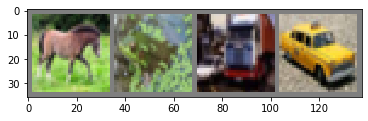

horse  frog truck   car


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [10]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
def configure_optimizer():
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    return optimizer

In [11]:
def train():
    for epoch in range(1):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

          # get the inputs; data is a list of [inputs, labels]
          # zero the parameter gradients
            configure_optimizer().zero_grad()

          # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            configure_optimizer().step()

          # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    return net.state_dict()   

    #print('Finished Training')

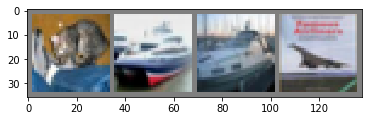

GroundTruth:    cat  ship  ship plane


In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [13]:
import statistics
def evaluate(net,net_state_dict):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    lis = []
    for i in range(10):
#         print('Accuracy of %5s : %2d %%' % (
#             classes[i], 100 * class_correct[i] / class_total[i]))
        test_acc = 100 * class_correct[i] / class_total[i]
        lis.append(test_acc)
    test_accuracy = statistics.mean(lis)
    return test_accuracy

In [14]:
def train_evaluate(parameterization):
    net = Net()
    net_state_dict = train()
    return evaluate(net,net_state_dict)

In [15]:
if not mlflow.active_run():
    mlflow.start_run(run_name="ParentRun")
    auto_end_run = True
else:
    auto_end_run = False
net = Net()
tempdir = tempfile.mkdtemp()
try:
    summary_file = os.path.join(tempdir, "model_summary.txt")
    with open(summary_file, "w") as f:
        for name, module in net.named_modules():
            f.write(str(module))

    mlflow.log_artifact(summary_file, "summary")
finally:
    shutil.rmtree(tempdir)

opt = configure_optimizer()
opt_param = opt.state_dict()["param_groups"]


for param in opt_param:
    for k,v in param.items():
        mlflow.log_param(k,v)
# total_trials = 2
# best_parameters, values, experiment, model = optimize(
# parameters=[
#     {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},
#     {"name": "momentum", "type": "range", "bounds": [0.0, 1.0]},
# ],
# evaluation_function=train_evaluate,
# objective_name='test_accuracy',
# total_trials = total_trials)
# means, covariances = values
# # print(means)
# # print(f"\nBest parameters: {best_parameters}\n")
# # print(f"Test accuracy: {means} Â± {covariances}")
# for t in range(total_trials):
#     with mlflow.start_run(nested=True,run_name="Trial "+str(t)) as child_run:
#         for i , v in experiment.trials[t].arm.parameters.items():
#             #print(i,v)
#             mlflow.log_param(str(i),v)
#         for i in experiment.fetch_data().df["mean"]:
#             mlflow.log_metric("HPT_test_accuracy", i)

# for k, v in best_parameters.items():
#     mlflow.log_param("optimum " + k, v)
        
from ax.service.ax_client import AxClient

ax_client = AxClient()
ax_client.create_experiment(
    parameters=[
        {
            "name": "lr",
            "type": "range",
            "bounds": [1e-6, 0.4],
            "log_scale": True,
        },
        {
            "name": "momentum",
            "type": "range",
            "bounds": [0.0, 1.0],
        },
    ],
    objective_name="test_accuracy",
)

total_trials = 10

for i in range(total_trials):
    with mlflow.start_run(nested=True, run_name="Trial "+ str(i)) as child_run:

        parameters, trial_index = ax_client.get_next_trial()
        
        # log params to MLFlow
        for param_name, value in parameters.items():
            mlflow.log_param(param_name, value)
        
        # evaluate params
        test_accuracy = train_evaluate(parameters)
        
        # log metric to MLFlow
        mlflow.log_metric("test_accuracy", test_accuracy)
        
        ax_client.complete_trial(trial_index=trial_index, raw_data=test_accuracy)

best_parameters, metrics = ax_client.get_best_parameters()

for param_name, value in best_parameters.items():
    mlflow.log_param("optimum " + param_name, value)
    
    
    
mlflow.end_run()

[INFO 08-07 03:10:42] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 2 decimal points.
[INFO 08-07 03:10:42] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 arms, GPEI for subsequent arms], generated 0 arm(s) so far). Iterations after 5 will take longer to generate due to model-fitting.
[INFO 08-07 03:10:42] ax.service.ax_client: Generated new trial 0 with parameters {'lr': 0.09, 'momentum': 0.57}.


[1,  2000] loss: 2.303
[1,  4000] loss: 2.297
[1,  6000] loss: 2.290
[1,  8000] loss: 2.272
[1, 10000] loss: 2.203
[1, 12000] loss: 2.132


[INFO 08-07 03:11:23] ax.service.ax_client: Completed trial 0 with data: {'test_accuracy': (10.01, None)}.
[INFO 08-07 03:11:23] ax.service.ax_client: Generated new trial 1 with parameters {'lr': 0.0, 'momentum': 0.94}.


[1,  2000] loss: 2.054
[1,  4000] loss: 1.988
[1,  6000] loss: 1.914
[1,  8000] loss: 1.867
[1, 10000] loss: 1.804
[1, 12000] loss: 1.748


[INFO 08-07 03:12:04] ax.service.ax_client: Completed trial 1 with data: {'test_accuracy': (10.0, None)}.
[INFO 08-07 03:12:04] ax.service.ax_client: Generated new trial 2 with parameters {'lr': 0.0, 'momentum': 0.19}.


[1,  2000] loss: 1.683
[1,  4000] loss: 1.651
[1,  6000] loss: 1.632
[1,  8000] loss: 1.624
[1, 10000] loss: 1.598
[1, 12000] loss: 1.549


[INFO 08-07 03:12:45] ax.service.ax_client: Completed trial 2 with data: {'test_accuracy': (10.0, None)}.
[INFO 08-07 03:12:45] ax.service.ax_client: Generated new trial 3 with parameters {'lr': 0.0, 'momentum': 0.36}.


[1,  2000] loss: 1.542
[1,  4000] loss: 1.523
[1,  6000] loss: 1.496
[1,  8000] loss: 1.490
[1, 10000] loss: 1.498
[1, 12000] loss: 1.454


[INFO 08-07 03:13:25] ax.service.ax_client: Completed trial 3 with data: {'test_accuracy': (9.62, None)}.
[INFO 08-07 03:13:25] ax.service.ax_client: Generated new trial 4 with parameters {'lr': 0.0, 'momentum': 0.77}.


[1,  2000] loss: 1.449
[1,  4000] loss: 1.411
[1,  6000] loss: 1.437
[1,  8000] loss: 1.405
[1, 10000] loss: 1.396
[1, 12000] loss: 1.401


[INFO 08-07 03:14:06] ax.service.ax_client: Completed trial 4 with data: {'test_accuracy': (9.42, None)}.
[INFO 08-07 03:14:07] ax.service.ax_client: Generated new trial 5 with parameters {'lr': 0.4, 'momentum': 1.0}.


[1,  2000] loss: 1.364
[1,  4000] loss: 1.356
[1,  6000] loss: 1.357
[1,  8000] loss: 1.360
[1, 10000] loss: 1.341
[1, 12000] loss: 1.336


[INFO 08-07 03:14:48] ax.service.ax_client: Completed trial 5 with data: {'test_accuracy': (12.08, None)}.
[INFO 08-07 03:14:48] ModelBridge: Leaving out out-of-design observations for arms: 5_0
[INFO 08-07 03:14:48] ax.service.ax_client: Generated new trial 6 with parameters {'lr': 0.4, 'momentum': 1.0}.


[1,  2000] loss: 1.317
[1,  4000] loss: 1.304
[1,  6000] loss: 1.299
[1,  8000] loss: 1.294
[1, 10000] loss: 1.293
[1, 12000] loss: 1.268


[INFO 08-07 03:15:29] ax.service.ax_client: Completed trial 6 with data: {'test_accuracy': (7.66, None)}.
[INFO 08-07 03:15:29] ModelBridge: Leaving out out-of-design observations for arms: 6_0, 5_0
[INFO 08-07 03:15:29] ax.service.ax_client: Generated new trial 7 with parameters {'lr': 0.4, 'momentum': 1.0}.


[1,  2000] loss: 1.260
[1,  4000] loss: 1.258
[1,  6000] loss: 1.240
[1,  8000] loss: 1.258
[1, 10000] loss: 1.249
[1, 12000] loss: 1.236


[INFO 08-07 03:16:10] ax.service.ax_client: Completed trial 7 with data: {'test_accuracy': (10.53, None)}.
[INFO 08-07 03:16:10] ModelBridge: Leaving out out-of-design observations for arms: 6_0, 5_0
[INFO 08-07 03:16:10] ax.service.ax_client: Generated new trial 8 with parameters {'lr': 0.04, 'momentum': 1.0}.


[1,  2000] loss: 1.208
[1,  4000] loss: 1.207
[1,  6000] loss: 1.205
[1,  8000] loss: 1.224
[1, 10000] loss: 1.192
[1, 12000] loss: 1.201


[INFO 08-07 03:16:51] ax.service.ax_client: Completed trial 8 with data: {'test_accuracy': (10.25, None)}.
[INFO 08-07 03:16:51] ModelBridge: Leaving out out-of-design observations for arms: 6_0, 5_0
[INFO 08-07 03:16:51] ax.service.ax_client: Generated new trial 9 with parameters {'lr': 0.4, 'momentum': 0.85}.


[1,  2000] loss: 1.157
[1,  4000] loss: 1.167
[1,  6000] loss: 1.181
[1,  8000] loss: 1.166
[1, 10000] loss: 1.168
[1, 12000] loss: 1.171


[INFO 08-07 03:17:33] ax.service.ax_client: Completed trial 9 with data: {'test_accuracy': (10.0, None)}.


In [16]:
best_parameters

{'lr': 0.39999999999999686, 'momentum': 0.9999999999999999}

In [17]:
metrics


({'test_accuracy': 10.441008310536493},
 {'test_accuracy': {'test_accuracy': 0.01903404889307984}})